# Credit Card Fraud Detection (Modeling, Notebook 2)
Author: Brenda De Leon

In this notebook we will compare different methods to addressing the dataset's high imbalance. We will see which method works best for the data we have been provided, with an overwhelming majority class. With the minority class only representing 0.0017 of the cases, we will try: oversampling, undersampling, and SMOTE, as well as compare between scalers (with a grid search and column transformer pipelines). We will create models using: Logistic Regression, SVMs, Decision trees, and KNN. Additionally, we will use metrics calculated using the confusion matrix and ROC curves to inform us of the models performance.

#### Libraries

In [31]:
# importing libraries
# importing libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
plt.style.use('ggplot')

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error, plot_confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, plot_roc_curve, confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve, auc, PrecisionRecallDisplay, average_precision_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
import warnings
warnings.filterwarnings("ignore")

In [14]:
# importing data
# importing dataset
df = pd.read_csv('data/creditcard.csv')
df.head().append(df.tail())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


## Evaluation Function

In [15]:
# defining an evaluation classification function for automation and evaluating subsequent models
def evaluate_classification(model, X_train, X_test, y_train, y_test, classes=None, 
                            normalize='true', cmap='cividis', label=''):
    
    """Input a model, training data and test data to return sklearn metrics
        - Classification Report for training and test 
        - PR AUC Score for training and test 
        - Confusion Matrix for training and test 
        - ROC Curve for training and test
        - PR Curve for training and test
        
        Args:
        model: instantiated classifier (ex: LogisticRegression = log_reg)
        X_train: train_test_split & preprocessed
        X_test: train_test_split 
        y_train: train_test_split & preprocessed
        y_test: train_test_split 
        label: optional label for type of classifier 
        
        Modified Function, Citation:
        https://github.com/hpatel530/Chicago-Car-Crash-Data/blob/master/Chicage_Car_Crash.ipynb
    """
    # retrieve predictions for train and test data 
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # retrieve probabilites for train and test data 
    y_hat_train = model.predict_proba(X_train)
    y_hat_test = model.predict_proba(X_test)
    
    # retrieve probabilities for the positive class
    pos_probs_train = y_hat_train[:, 1]
    pos_probs_test = y_hat_test[:, 1]
    
    # print training classification report 
    header = label + " CLASSIFICATION REPORT TRAINING "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names=classes))
    
    # calculate precision-recall area under curve
    # print training ap score
    # ap_score = average_precision_score(y_train, y_pred_train)
    # print('Training Area Under Precision-Recall Curve, measured by Average Precision score: %.3f' % ap_score)
     
    # display training figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
    
    # plot confusion matrix 
    plot_confusion_matrix(model, X_train, y_train, labels=classes,
                         cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix Training')
    
    # plot ROC curve 
    plot_roc_curve(model, X_train, y_train, ax=axes[1], name=label)
    roc = axes[1]
    roc.plot([0,1], [0,1], ls=':', label='No Skill')
    roc.grid()
    roc.set_title('Receiving Operator Characteristic Training')
    
    # plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Training')
    plt.show()

    # print testing classification report 
    header_ = label + " CLASSIFICATION REPORT TESTING "
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_test, y_pred_test, target_names=classes))
    
    # calculate precision-recall area under curve
    # print testing ap score
    # ap_score = average_precision_score(y_test, y_pred_test)
    # print('Test Area Under Precision-Recall Curve, measured by Average Precision score: %.3f' % ap_score)
    
    # display testing figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    
    # plot confusion matrix 
    plot_confusion_matrix(model, X_test, y_test, labels=classes, 
                          cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix Testing')
    
    # plot ROC curve 
    plot_roc_curve(model, X_test, y_test, ax=axes[1], name=label)
    axes[1].plot([0,1], [0,1], ls=':', label='No Skill')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic Test')

    # plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Test')
    plt.legend()
    plt.show()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Data Split

In [17]:
# defining x and y for data split
X = df.drop('Class', axis = 1).values
y = df['Class'].values
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# train test split to have a validation set
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('X_train samples : ', X_train[:1])
print('X_test samples : ', X_test[0:1])
print('y_train samples : ',  y_train[0:10])
print('y_test samples : ',  y_test[0:10])

print('X_t samples : ', X_t[:1])
print('X_val samples : ', X_val[0:1])
print('y_t samples : ',  y_t[0:10])
print('y_val samples : ',  y_val[0:10])

X_train samples :  [[ 1.43352000e+05  1.95504092e+00 -3.80782711e-01 -3.15012853e-01
   3.30155452e-01 -5.09374248e-01 -8.61974532e-02 -6.27977906e-01
   3.59937221e-02  1.05456030e+00 -3.04413407e-02  6.24995774e-01
   1.69149569e+00  1.25579040e+00 -2.53266461e-01 -3.31694981e-01
   3.07252346e-01 -9.30843692e-01  6.51665792e-01  1.67986640e-01
  -1.25389994e-01  2.38197424e-01  9.68304938e-01  5.32080152e-02
  -2.78601509e-01 -4.49993014e-02 -2.16780337e-01  4.51682478e-02
  -4.71447917e-02  9.99000000e+00]]
X_test samples :  [[ 4.15050000e+04 -1.65265066e+01  8.58497180e+00 -1.86498532e+01
   9.50559352e+00 -1.37938185e+01 -2.83240430e+00 -1.67016943e+01
   7.51734390e+00 -8.50705864e+00 -1.41101844e+01  5.29923635e+00
  -1.08340065e+01  1.67112025e+00 -9.37385858e+00  3.60805642e-01
  -9.89924654e+00 -1.92362924e+01 -8.39855199e+00  3.10173537e+00
  -1.51492344e+00  1.19073869e+00 -1.12767001e+00 -2.35857877e+00
   6.73461329e-01 -1.41369967e+00 -4.62762361e-01 -2.01857525e+00
  -

## Pipeline Building

While the 28 anonymized columns have gone through some standardization before having been transformed through PCA, columns: 'Time' and 'Amount' need to be standardized so that each variable contributes equally to the analysis. 
Will time be standardized the same? (addres now or save for next steps)
Here we will try scaling and robust scaling maybe also removing outliers?

In [18]:
min(df.Amount), max(df.Amount)

(0.0, 25691.16)

The Amount variables vary widely and can confuse our models. We definetely want to reduce the large differences. 

In [32]:
# scale amount by log
df['amount_log'] = np.log(df.Amount + 0.01)

# scale amount by Standardization
ss = StandardScaler()
df['amount_scaled'] = ss.fit_transform(df['Amount'].values.reshape(-1,1))

# scale amount by Normalization
norm = MinMaxScaler()
df['amount_minmax'] = norm.fit_transform(df['Amount'].values.reshape(-1,1))

# scale amount by Robust
rs = RobustScaler()
df['amount_robust'] = rs.fit_transform(df['Amount'].values.reshape(-1,1))

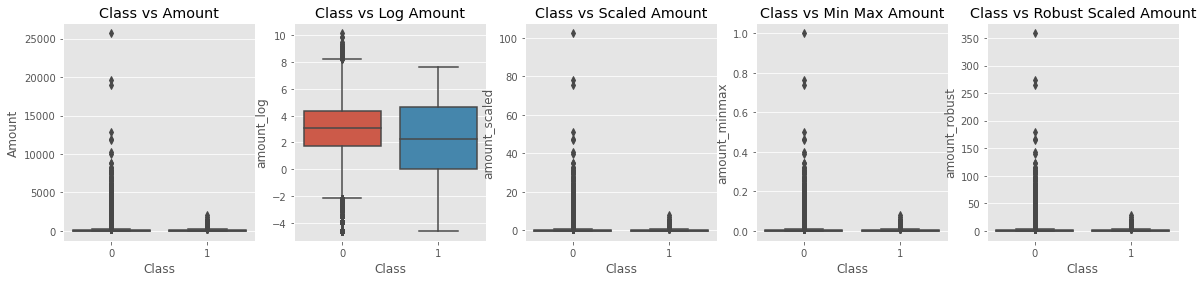

In [33]:
fig,axs = plt.subplots(nrows = 1 , ncols = 5 , figsize = (20,4))

sns.boxplot(x ="Class",y="Amount",data=df, ax = axs[0])
axs[0].set_title("Class vs Amount")

sns.boxplot(x ="Class",y="amount_log",data=df, ax = axs[1])
axs[1].set_title("Class vs Log Amount")

sns.boxplot(x ="Class",y="amount_scaled",data=df, ax = axs[2])
axs[2].set_title("Class vs Scaled Amount")

sns.boxplot(x ="Class",y="amount_minmax",data=df, ax = axs[3])
axs[3].set_title("Class vs Min Max Amount")

sns.boxplot(x ="Class",y="amount_robust",data=df, ax = axs[4])
axs[4].set_title("Class vs Robust Scaled Amount")

plt.show()

In [ ]:
Note: Move forward with the best scaler

In [23]:
# categorical mini-pipeline for columntransformer. X, X_train, X_test have no numeric dtypes. 
# will return sparse matrix where each column corresponds to one possible value of one feature, default parameter
subpipe_robust = Pipeline(steps=[
    ('robustscaler', RobustScaler())
])

In [20]:
# df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].reshape(-1, 1))

### Column Transformer
Pipelines will include columntransformer ('CT') to take care of preprocessing & adding data back into original dataset

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [24]:
# creating columntransformer as 'CT'
# columntransformer will one hot encode all non np.number dtypes
# remainder data will pass through without transformation, instead of being dropped
CT = ColumnTransformer(transformers=[('subpipe_robust', subpipe_robust, [29])])

## Metric
#### Recall 

## Modeling

### Dummy Classfier

In [25]:
# pipeline will preprocess data and instantiate estimator
dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

In [26]:
# fit pipeline to training data
dummy_model_pipe.fit(X_t, y_t)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_robust',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  [29])])),
                ('dum', DummyClassifier(strategy='most_frequent'))])

------------------------------------------------------------
Dummy Model CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181946
           1       0.00      0.00      0.00       330

    accuracy                           1.00    182276
   macro avg       0.50      0.50      0.50    182276
weighted avg       1.00      1.00      1.00    182276



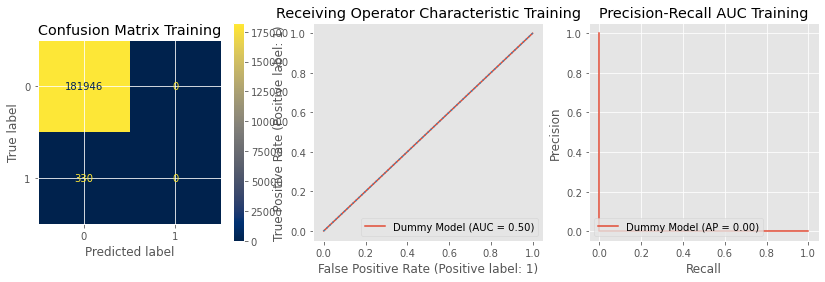

------------------------------------------------------------
Dummy Model CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45505
           1       0.00      0.00      0.00        64

    accuracy                           1.00     45569
   macro avg       0.50      0.50      0.50     45569
weighted avg       1.00      1.00      1.00     45569



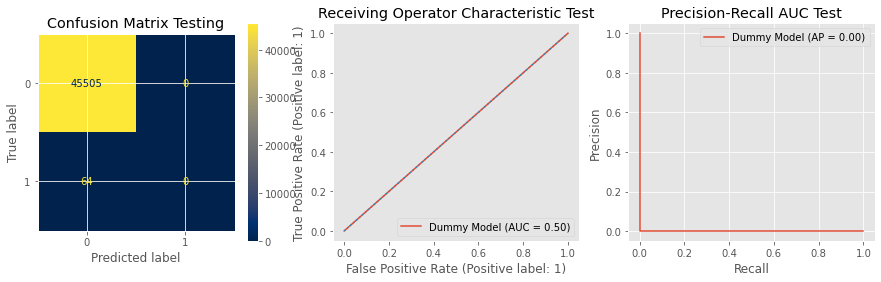

In [27]:
# classification report using function 
evaluate_classification(dummy_model_pipe,
                        X_t, 
                        X_val, 
                        y_t, 
                        y_val, 
                        label='Dummy Model')

In [29]:
yhat = dummy_model_pipe.predict(X_test)
yhat

array([0, 0, 0, ..., 0, 0, 0])

In [10]:


# pipeline will preprocess data and instantiate estimator
dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy='most_frequent'))
])



In [11]:


# fit pipeline to training data
dummy_model_pipe.fit(X_train, y_train)



Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  [29])])),
                ('dum', DummyClassifier(strategy='most_frequent'))])

------------------------------------------------------------
Dummy Model CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.00      0.00      0.00       394

    accuracy                           1.00    227845
   macro avg       0.50      0.50      0.50    227845
weighted avg       1.00      1.00      1.00    227845



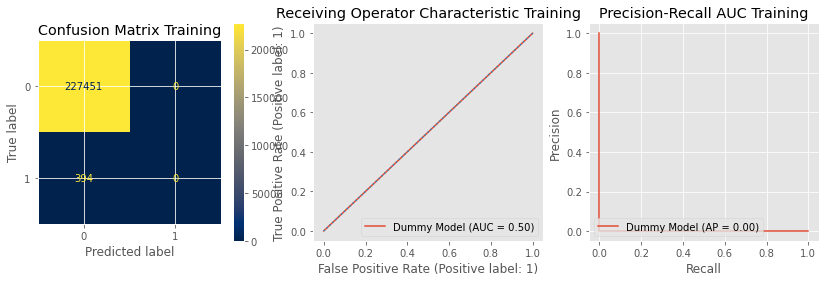

------------------------------------------------------------
Dummy Model CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



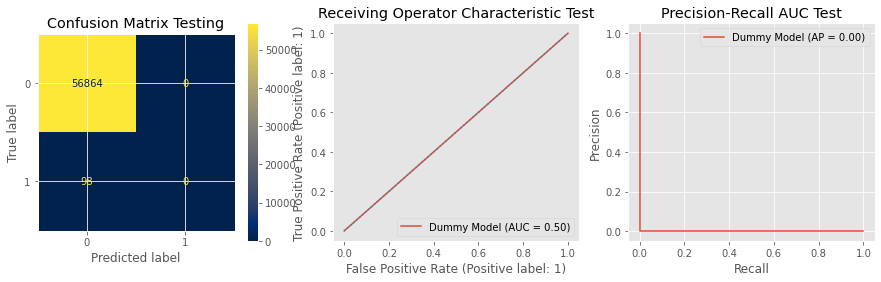

In [12]:
# classification report using function 
evaluate_classification(dummy_model_pipe,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Dummy Model')

## Logistic Regression

In [13]:
# pipeline will preprocess data and instantiate estimator
logreg_model = Pipeline(steps=[
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42))
])

In [14]:
# fit pipeline to training data
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  [29])])),
                ('logreg', LogisticRegression(random_state=42))])

------------------------------------------------------------
Logistic Regression Model CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.00      0.00      0.00       394

    accuracy                           1.00    227845
   macro avg       0.50      0.50      0.50    227845
weighted avg       1.00      1.00      1.00    227845



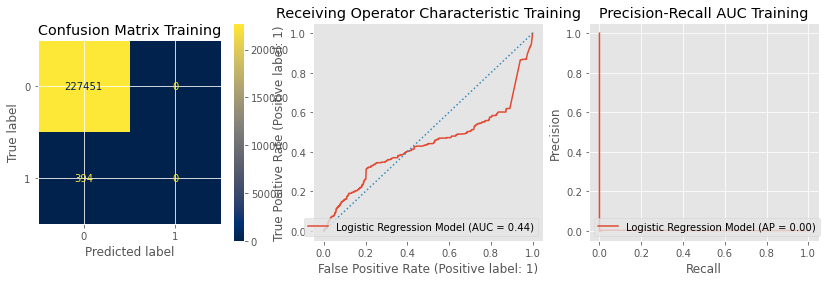

------------------------------------------------------------
Logistic Regression Model CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



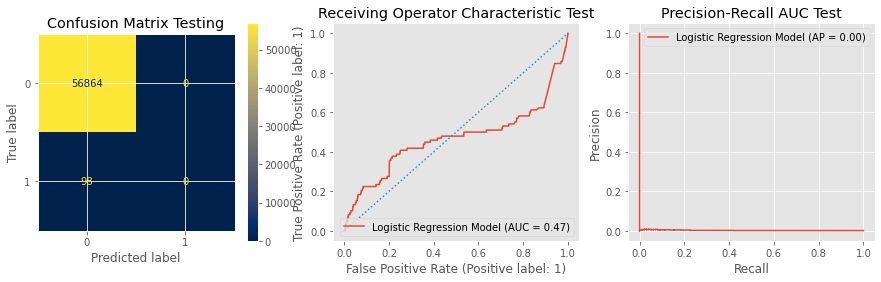

In [15]:
# classification report using function 
evaluate_classification(logreg_model,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Logistic Regression Model')


In [ ]:
My plan was to create the validation set by performing a second train_test_split on X_train, as so:
X into X_train and X_test
X_train into x_t and x_val

crossvalidate with pipeline (x_t)
test with x_val
final test with X_test


Robust Scaling v standard scaler 

next step?

oversampling, undersampling smote, scaling, or removing outliers, or weighing? best method to deal with severe imbalance (and why)

m